In [1]:
from numcosmo_py import Ncm, Nc
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from matplotlib.pyplot import cm
from scipy.special import erfc, erf
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from numcosmo_py.plotting.tools import set_rc_params_article, latex_float

In [2]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
set_rc_params_article(ncol=2)

In [4]:
qgw = Nc.HICosmoQGW.new()
adiab = Nc.HIPertAdiab.new()

In [5]:
qgw.props.xb = 1.0e35
qgw.props.w = 1.0e-18

In [6]:

tAi = -300.0
tAf = -5.0e-2

ki = 1.0e0
kf = 1.0e2
k_a = np.geomspace(ki, kf, 1000)

adiab.set_k(1.0e-1)
adiab.set_ti(-300.0)
adiab.set_tf(-1.0)
adiab.set_reltol(1.0e-11)
adiab.set_max_order_2(False)

Found, tAD = adiab.find_adiab_time_limit(qgw, tAi, tAf, 1.0e-3)

print(f"Found: {Found}, tAD: {tAD}")

Found: True, tAD: -195.13222836792218


In [7]:
adiab.set_init_cond_adiab(qgw, tAD)
adiab.prepare(qgw)

In [8]:
ta, ts = adiab.get_time_array()

In [9]:
Pzeta = [adiab.eval_powspec_zeta_at(qgw, t) for t in ta]
PPsi = [adiab.eval_powspec_Psi_at(qgw, t) for t in ta]
Pdrho = [adiab.eval_powspec_drho_at(qgw, t) for t in ta]

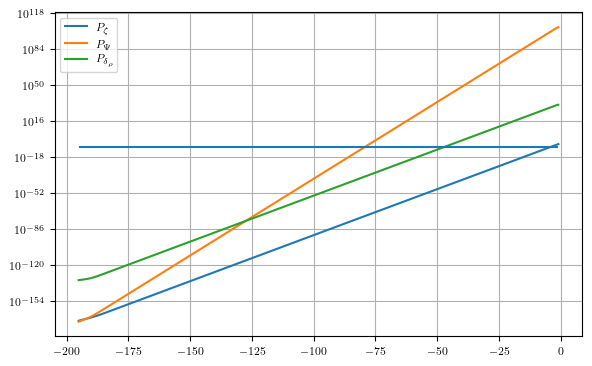

In [10]:
fig = plt.figure()

plt.plot(ta, Pzeta, label="$P_\zeta$")
plt.plot(ta, PPsi, label="$P_\Psi$")
plt.plot(ta, Pdrho, label=r"$P_{\delta_\rho}$")

plt.hlines(2.0e-9, xmin=min(ta), xmax=max(ta))
plt.yscale('log')

plt.grid()
plt.legend()

In [11]:
adiab.eval_cosmic_time(qgw, -170)
pass

In [12]:
def tau_jeans_k(k):
    t0 = (qgw.props.xb * 3.0 * qgw.props.Omegaw / (k**2 * qgw.props.w * 2.0))**(1.5)
    return -math.acosh(t0 if t0 > 1.0 else 1.0)

def tau_hubble_k(k):
    t0 = (qgw.props.xb * qgw.props.Omegaw / k**2)**(1.5)
    return -math.acosh(t0 if t0 > 1.0 else 1.0)

2.720294101700019e-27


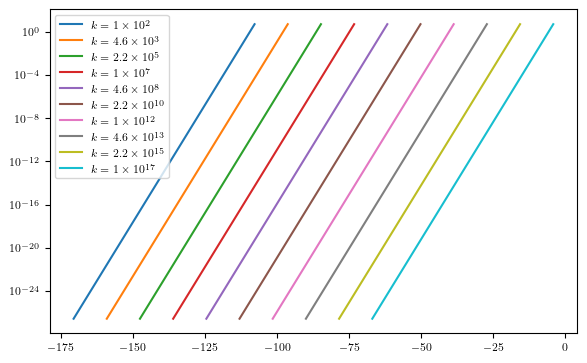

In [13]:
for k in np.geomspace(1.0e2, 1.0e17, 10):
    adiab.set_k(k)
    tau_min = tau_jeans_k(k)
    tau_max = tau_hubble_k(k)
    tau_l_a = np.linspace(tau_min, tau_max, 100)

    plt.plot(tau_l_a, [adiab.eval_delta_critial(qgw, tau) for tau in tau_l_a], label=rf"$k={latex_float(k)}$")

print(adiab.eval_delta_critial(qgw, tau_jeans_k(k)))

plt.yscale('log')
plt.legend()
pass

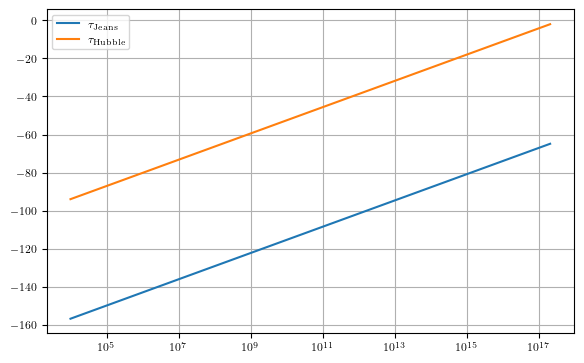

In [14]:
fig = plt.figure()

ka = np.geomspace(1.0e4, 2.0e17, 1000)
tau_jeans_a = [tau_jeans_k(k) for k in ka]
tau_hubble_a = [tau_hubble_k(k) for k in ka]
tau_a = np.linspace(min(tau_jeans_a), max(tau_hubble_a), 120)

plt.plot(ka, tau_jeans_a, label=rf"$\tau_\mathrm{{Jeans}}$")
plt.plot(ka, tau_hubble_a, label=rf"$\tau_\mathrm{{Hubble}}$")

plt.xscale('log')

plt.grid()
plt.legend()
pass

In [15]:
ka = np.geomspace(1.0e2, 1.0e20, 1000)
tau_a = np.linspace(-120.0, -10.0, 500)
adiab.prepare_spectrum(qgw, -1.0e-15, 1.0e-7, ka, tau_a)

In [16]:
ka = np.geomspace(1.0e2, 1.0e21, 1000)

In [17]:
Pzetak = adiab.eval_powspec_zeta(qgw)
#Pzetak.set_kmax(1.0e21)
PPsik = adiab.eval_powspec_Psi(qgw)
#PPsik.set_kmax(1.0e21)
Pdrhok = adiab.eval_powspec_drho(qgw)
#Pdrhok.set_kmax(1.0e21)

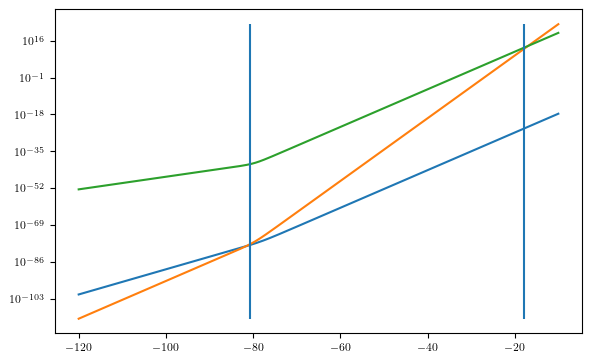

In [18]:
fig = plt.figure()

k = 1.0e15

ymin = 1.0e300
ymax = 1.0e-300

tau = tau_jeans_k(k)

Ps = [k**3 * 0.5 / np.pi**2 * Pzetak.eval(None, tau, k) for tau in tau_a]
plt.plot(tau_a, Ps, label=f"$P_\zeta({latex_float(tau)})$")

ymin = np.min(np.concatenate((Ps, [ymin])))
ymax = np.max(np.concatenate((Ps, [ymax])))

Ps = [k**3 * 0.5 / np.pi**2 * PPsik.eval(None, tau, k) for tau in tau_a]
plt.plot(tau_a, Ps, label=f"$P_\Psi({latex_float(tau)})$")

ymin = np.min(np.concatenate((Ps, [ymin])))
ymax = np.max(np.concatenate((Ps, [ymax])))

Ps = [k**3 * 0.5 / np.pi**2 * Pdrhok.eval(None, tau, k) for tau in tau_a]
plt.plot(tau_a, Ps, label=f"$P_\Psi({latex_float(tau)})$")

ymin = np.min(np.concatenate((Ps, [ymin])))
ymax = np.max(np.concatenate((Ps, [ymax])))

plt.vlines([tau_jeans_k(k), tau_hubble_k(k)], ymin=ymin, ymax=ymax)

plt.yscale('log')

pass

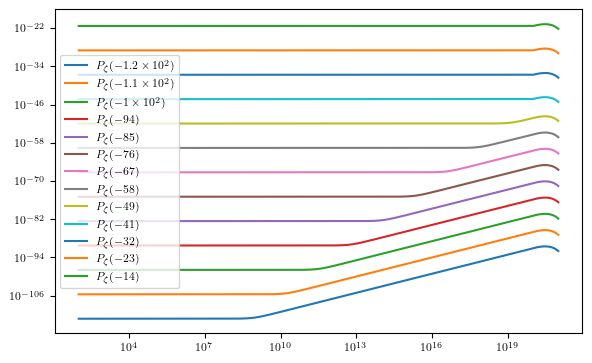

In [19]:
fig = plt.figure()

tau_plot_a = tau_a[::40]
for tau in tau_plot_a:
    Ps = [k**3 * 0.5 / np.pi**2 * Pzetak.eval(None, tau, k) for k in ka]
    plt.plot(ka, Ps, label=f"$P_\zeta({latex_float(tau)})$")

plt.xscale('log')
plt.yscale('log')
plt.legend()
pass

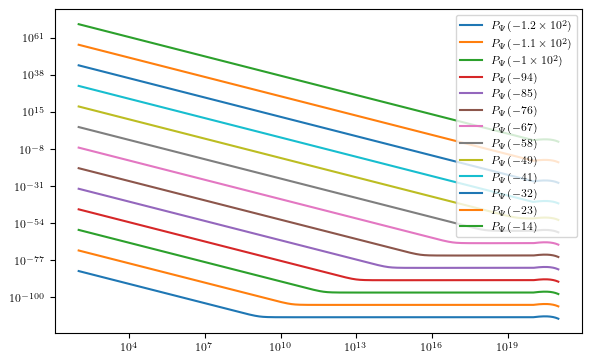

In [20]:
fig = plt.figure()

for tau in tau_plot_a:
    plt.plot(ka, [k**3 * 0.5 / np.pi**2 * PPsik.eval(None, tau, k) for k in ka], label=rf"$P_\Psi({latex_float(tau)})$")

plt.xscale('log')
plt.yscale('log')
plt.legend()
pass

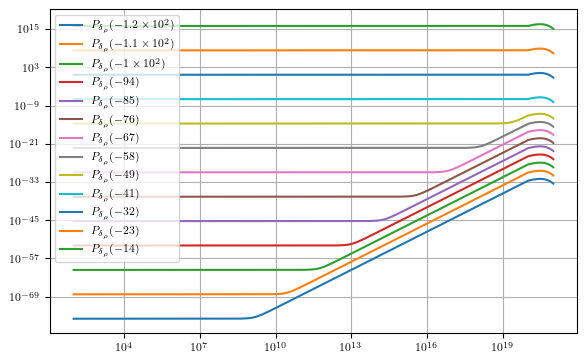

In [21]:
fig = plt.figure()

for tau in tau_plot_a:
    plt.plot(ka, [k**3 * 0.5 / np.pi**2 * Pdrhok.eval(None, tau, k) for k in ka], label=rf"$P_{{\delta_\rho}}({latex_float(tau)})$")

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
pass

In [22]:
psf_zeta = Ncm.PowspecFilter.new(Pzetak, Ncm.PowspecFilterType.TOPHAT)
psf_zeta.set_best_lnr0()
psf_zeta.set_reltol(1.0e-1)

psf_Psi = Ncm.PowspecFilter.new(PPsik, Ncm.PowspecFilterType.TOPHAT)
psf_Psi.set_best_lnr0()
psf_Psi.set_reltol(1.0e-1)

psf_drho = Ncm.PowspecFilter.new(Pdrhok, Ncm.PowspecFilterType.TOPHAT)
psf_drho.set_best_lnr0()
psf_drho.set_reltol(1.0e-1)

In [23]:
psf_zeta.prepare(qgw)
psf_drho.prepare(qgw)
psf_Psi.prepare(qgw)


(process:137804): NUMCOSMO-WARNING **: 15:44:23.644: ncm_spline_new_function_spline: cannot archive requested precision with at most 500 nodes

(process:137804): NUMCOSMO-WARNING **: 15:44:24.185: ncm_spline_new_function_spline: cannot archive requested precision with at most 500 nodes

(process:137804): NUMCOSMO-WARNING **: 15:44:24.743: ncm_spline_new_function_spline: cannot archive requested precision with at most 500 nodes


1.5747260785739427e-14


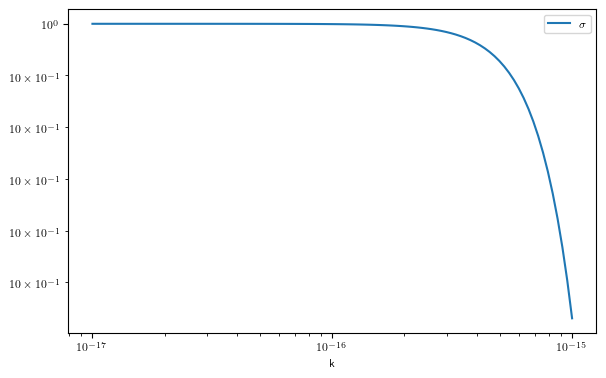

In [24]:
fig = plt.figure()

k_a_test = np.geomspace(1.0e15, 1.0e17, 100)

sigma_c_a = []
for k in k_a_test:
    adiab.set_k(k)
    sigma_c_a.append(adiab.eval_delta_critial(qgw, tau_jeans_k(k)))

sigma_c_a = np.array(sigma_c_a)

plt.plot(1.0/k_a_test, [erfc(sigma_c/(np.sqrt(2.0) * Pdrhok.sigma_tophat_R(qgw, 1.0e-4, tau_jeans_k(k), 1.0 / k))) for k, sigma_c in zip(k_a_test, sigma_c_a)], label=r"$\sigma$")
#plt.plot(k_a_test, sigma_c_a, label=r"$\delta_c$")

k = 1.0e17
print(Pdrhok.sigma_tophat_R(qgw, 1.0e-4, tau_jeans_k(k), 1.0 / k))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.legend()
pass

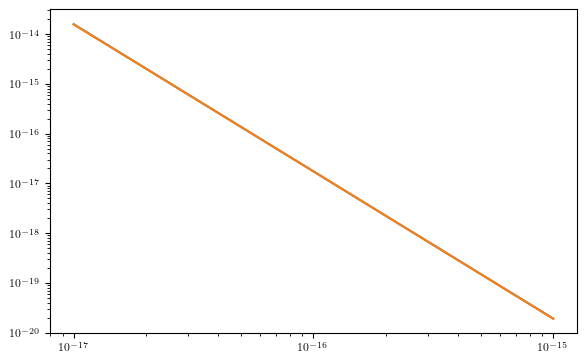

In [25]:
fig = plt.figure()

k_a_test = np.geomspace(1.0e15, 1.0e17, 100)

sigma_c_a = []
for k in k_a_test:
    adiab.set_k(k)
    sigma_c_a.append(adiab.eval_delta_critial(qgw, tau_jeans_k(k)))

sigma_c_a = np.array(sigma_c_a)
sigma_drho = [Pdrhok.sigma_tophat_R(qgw, 1.0e-4, tau_jeans_k(k), 1.0 / k) for k in k_a_test]

sigma_drho_poly = np.polyfit(np.log(k_a_test), np.log(sigma_drho), 1)
def sigma_drho_fit(k):
    return np.exp(sigma_drho_poly[0] * np.log(k) + sigma_drho_poly[1])

plt.plot(1.0 / k_a_test, sigma_drho_fit(k_a_test), label=r"$\sigma$")
plt.plot(1.0 / k_a_test, [Pdrhok.sigma_tophat_R(qgw, 1.0e-4, tau_jeans_k(k), 1.0 / k) for k, sigma_c in zip(k_a_test, sigma_c_a)], label=r"$\sigma$")

plt.xscale('log')
plt.yscale('log')

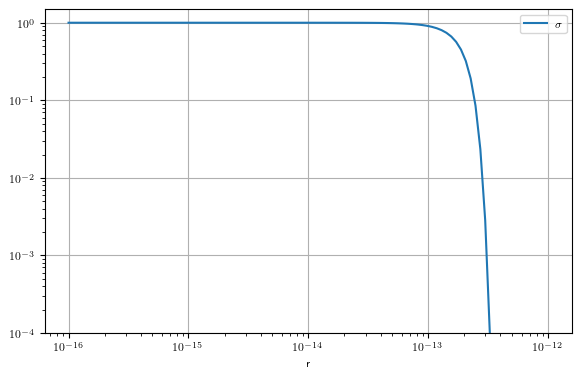

In [26]:
fig = plt.figure()

k_a_test = np.geomspace(1.0e12, 1.0e16, 100)

delta_c_a = []
for k in k_a_test:
    adiab.set_k(k)
    delta_c_a.append(adiab.eval_delta_critial(qgw, tau_jeans_k(k)))

sigma_c_a = np.array(sigma_c_a)

plt.plot(1.0/k_a_test, [erfc(delta_c/(np.sqrt(2.0)*sigma_drho_fit(k))) for k, delta_c in zip(k_a_test, delta_c_a)], label=r"$\sigma$")
#plt.plot(k_a_test, sigma_c_a, label=r"$\delta_c$")
#plt.hlines(1.0e-3, xmin=min(k_a_test), xmax=max(k_a_test))
k = 1.0e17

plt.ylim(1.0e-4, 1.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('r')
plt.legend()
plt.grid()
pass

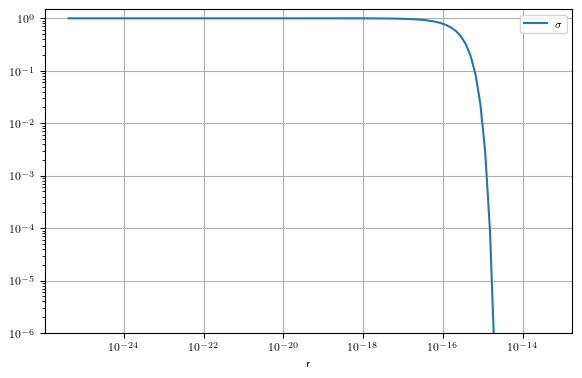

In [27]:
fig = plt.figure()

k_a_test = np.geomspace(1.0e12, 1.0e16, 100)

delta_c_a = []
for k in k_a_test:
    adiab.set_k(k)
    delta_c_a.append(adiab.eval_delta_critial(qgw, tau_jeans_k(k)))

sigma_c_a = np.array(sigma_c_a)

plt.plot(4.0 * np.pi * 1.0e22 / 3.0 * (1.0/k_a_test)**3, [erfc(delta_c/(np.sqrt(2.0)*sigma_drho_fit(k))) for k, delta_c in zip(k_a_test, delta_c_a)], label=r"$\sigma$")
#plt.plot(k_a_test, sigma_c_a, label=r"$\delta_c$")
#plt.hlines(1.0e-3, xmin=min(k_a_test), xmax=max(k_a_test))
k = 1.0e17

plt.ylim(1.0e-6, 1.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('r')
plt.legend()
plt.grid()
pass